<a href="https://colab.research.google.com/github/zenAurelius/HRAI3/blob/main/notebooks/test_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/HRAI/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/HRAI/data


In [26]:
df = pd.read_csv('pmu2016_os.zip')
df.head()

,aid_cr,rfs_date,rfs_heure,ris_nom,rfi_prix,rfi_distance,rfs_corde,rfs_condSexe,rfi_nbPartants,rfs_hippodrome,...,pff_ord_2,OS_D_MU_pis_cheval_1,OS_D_SG_pis_cheval_1,OS_N_MU_pis_cheval_1,OS_N_SG_pis_cheval_1,OS_D_MU_pis_driver_1,OS_D_SG_pis_driver_1,OS_N_MU_pis_driver_1,OS_N_SG_pis_driver_1,pff_pwin_1
0,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
1,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
2,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
3,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
4,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,1.964295,0.981306,26.964295,8.177963,1.964295,0.981306,26.964295,8.177963,0.5


In [3]:
#SELECTION DES FEATURES ET TARGET
#df = df[['rfi_prix','rfi_distance','pfi_chNbPlaces_1','pff_rapportDirect_1','pff_ord_1','pfi_chNbPlaces_2','pff_rapportDirect_2','pff_ord_2','tgf_win_1']].copy()
df = df[['pff_rapportDirect_1','pff_ord_1','pff_rapportDirect_2','pff_ord_2','tgf_win_1']].copy()
df = df[(~df.pff_rapportDirect_2.isna()) & (~df.pff_rapportDirect_1.isna())].copy()
df['diff_cote'] = df.pff_rapportDirect_2 - df.pff_rapportDirect_1
df['diff_ord'] = df.pff_ord_2 - df.pff_ord_1
df['tgf_win_1'] = df['tgf_win_1'].replace(0.5, 0)
df = df[['diff_cote','diff_ord', 'tgf_win_1']].copy()
df.head()

,diff_cote,diff_ord,tgf_win_1
0,-29.0,0.0,0.0
1,-8.0,0.0,0.0
2,-32.1,0.0,0.0
3,-30.4,0.0,0.0
4,61.0,0.0,1.0


In [ ]:
df[df.tgf_win_1.isna()]

,pff_rapportDirect_1,pff_ord_1,pff_rapportDirect_2,pff_ord_2,tgf_win_1


In [4]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')


1117404 training examples
139676 validation examples
139676 test examples


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('tgf_win_1')
  df = {key: np.array(value)[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [6]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [7]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)


In [9]:
all_inputs = []
encoded_features = []

# Numerical features.
#for header in ['rfi_prix', 'rfi_distance', 'pfi_chNbPlaces_1', 'pff_rapportDirect_1', 'pff_ord_1', 'pfi_chNbPlaces_2', 'pff_rapportDirect_2', 'pff_ord_2']:
for header in ['diff_cote', 'diff_ord']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [22]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)


In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])


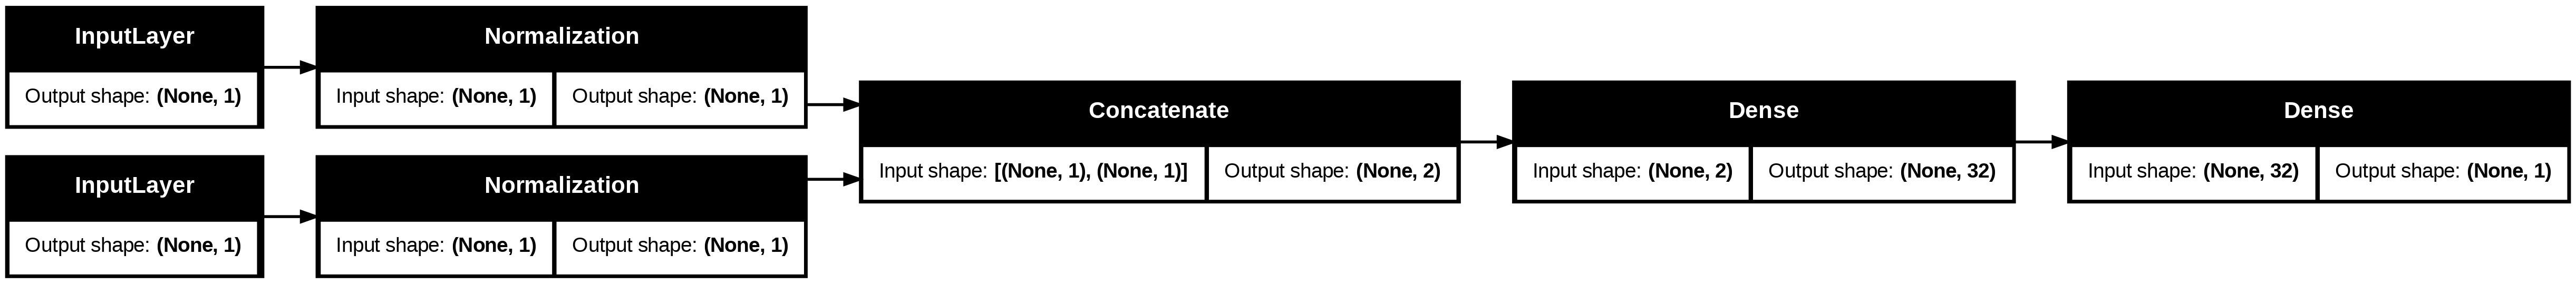

In [24]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [13]:
model.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.5732 - loss: 0.6589 - val_accuracy: 0.5769 - val_loss: 0.6485
Epoch 2/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.5761 - loss: 0.6521 - val_accuracy: 0.5784 - val_loss: 0.6482
Epoch 3/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.5759 - loss: 0.6519 - val_accuracy: 0.5770 - val_loss: 0.6479
Epoch 4/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.5767 - loss: 0.6515 - val_accuracy: 0.5786 - val_loss: 0.6479
Epoch 5/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.5761 - loss: 0.6520 - val_accuracy: 0.5744 - val_loss: 0.6480
Epoch 6/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5750 - loss: 0.6517 - val_accuracy: 0.5788 - val_loss: 0.6479
Epoch 7/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.5754 - loss: 0.6521 - val_accuracy: 0.5846 - val_loss: 0.6481
Epoch 8/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.5766 - loss: 0

In [14]:
model.save('classifier_test.keras')
reloaded_model = tf.keras.models.load_model('classifier_test.keras')

In [15]:
predictions = reloaded_model.predict(test_ds)
predictions

546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


array([[-1.6619827 ],
       [ 0.3150533 ],
       [-0.24223864],
       ...,
       [ 0.06306207],
       [ 0.2473118 ],
       [-0.75251555]], dtype=float32)

In [16]:
# prompt: je veux mettre le résultat des prédictions dans une colonne 'pred' du dataframe d'origine 'test'

# Convert predictions to a binary classification (e.g., using a threshold)
threshold = 0.0
binary_predictions = (predictions > threshold).astype(int)

# Add the predictions as a new column 'pred' to the test dataframe
test['pred'] = binary_predictions

# Print the updated dataframe with predictions
test

,diff_cote,diff_ord,tgf_win_1,pred
783711,-207.0,24.042599,0.0,0
553043,90.0,11.619337,1.0,1
434754,9.0,15.159743,1.0,0
1116025,-1.0,0.000000,0.0,0
1043166,13.0,-13.086537,1.0,1
...,...,...,...,...
1136079,57.7,-2.939516,1.0,1
191866,-38.8,14.835067,1.0,0
1133794,30.0,7.692819,1.0,1
274856,41.0,-7.130533,0.0,1


In [17]:
# prompt: dans dataframe 'test' je veux une colonne win_cote qui contient 1 si rapport 2 > rapport 1 et 0 sinon

test['win_cote'] = (test['diff_cote'] > 0).astype(int)
test['win_ord'] = (test['diff_ord'] < 0).astype(int)

In [19]:
test

,diff_cote,diff_ord,tgf_win_1,pred,win_cote,win_ord
783711,-207.0,24.042599,0.0,0,0,0
553043,90.0,11.619337,1.0,1,1,0
434754,9.0,15.159743,1.0,0,1,0
1116025,-1.0,0.000000,0.0,0,0,0
1043166,13.0,-13.086537,1.0,1,1,1
...,...,...,...,...,...,...
1136079,57.7,-2.939516,1.0,1,1,1
191866,-38.8,14.835067,1.0,0,0,0
1133794,30.0,7.692819,1.0,1,1,0
274856,41.0,-7.130533,0.0,1,1,1


In [20]:
print(len(test[(test.pred == 0) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))
print(len(test[(test.win_cote == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))
print(len(test[(test.win_ord == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))

0.5003072462854712
0.6330849102683285
0.5877227535569666


In [21]:
print(len(test[(test.pred == 1) & (test.tgf_win_1 == 0)]) / len(test[(test.tgf_win_1 == 0)]))
print(len(test[(test.win_cote == 0) & (test.tgf_win_1 == 0)]) / len(test[(test.tgf_win_1 == 0)]))
print(len(test[(test.win_ord == 0) & (test.tgf_win_1 == 0)]) / len(test[(test.tgf_win_1 == 0)]))

0.2675274573869228
0.6228660656877797
0.5823590389586532
